## Reproducible code for a dot graph of tissue blocks per organ per consortium in CFDE

## Install and import libraries

In [ ]:
%pip install requests pandas seaborn matplotlib

import os
from pprint import pprint
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Define functions

In [43]:
def download_if_not_exists(url, folder):
    os.makedirs(folder, exist_ok=True)

    filename = os.path.basename(url) + ".json"
    filepath = os.path.join(folder, filename)

    # If file exists → load and return JSON
    if os.path.exists(filepath):
        print(f"File already exists: {filepath}")
        with open(filepath, "r", encoding="utf-8") as f:
            return json.load(f)

    # Otherwise download
    response = requests.get(url)
    response.raise_for_status()

    data = response.json()  # parse JSON response

    # Save JSON
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

    print(f"Downloaded and saved: {filepath}")
    return data

## Load data from HRA API

In [44]:
# tissue_blocks_json = download_if_not_exists("https://apps.humanatlas.io/api/v1/ds-graph", "data")
tissue_blocks_json = download_if_not_exists("https://apps.humanatlas.io/api/v1/ds-graph", "downloads")

File already exists: downloads\ds-graph.json


## Preprocess data into correct format:
`organ, provider_name, count`


In [45]:
import pandas as pd

rows = []

for donor in tissue_blocks_json.get("@graph", []):
    for sample in donor.get("samples", []):
        rui = sample.get("rui_location")
        if not rui:
            continue

        # normalize rui_location to a list
        rui_entries = rui if isinstance(rui, list) else [rui]

        for rui_entry in rui_entries:
            if not isinstance(rui_entry, dict):
                continue

            placement = rui_entry.get("placement")
            if not placement:
                continue

            # normalize placement to a list
            placement_entries = (
                placement if isinstance(placement, list) else [placement]
            )

            for placement_entry in placement_entries:
                if not isinstance(placement_entry, dict):
                    continue

                target = placement_entry.get("target")
                if not target:
                    continue

                rows.append(
                    {
                        "organ": target,
                        "provider_name": donor.get("provider_name"),
                    }
                )

# build dataframe
df = pd.DataFrame(rows)
df


,organ,provider_name
0,http://purl.org/ccf/latest/ccf.owl#VHMRightKid...,KPMP-IU/OSU
1,http://purl.org/ccf/latest/ccf.owl#VHMRightKid...,KPMP-IU/OSU
2,http://purl.org/ccf/latest/ccf.owl#VHMRightKid...,KPMP-IU/OSU
3,http://purl.org/ccf/latest/ccf.owl#VHFLymphNode,NIH
4,http://purl.org/ccf/latest/ccf.owl#VHMPancreas,IsletCore
...,...,...
2368,http://purl.org/ccf/latest/ccf.owl#VHFLeftUreter,GUDMAP
2369,http://purl.org/ccf/latest/ccf.owl#VHMLeftUreter,GUDMAP
2370,http://purl.org/ccf/latest/ccf.owl#VHMLeftKidney,RBK
2371,https://purl.humanatlas.io/ref-organ/kidney-ma...,Indiana University


In [46]:
df["organ"] = df["organ"].apply(lambda x: "; ".join(x) if isinstance(x, list) else x)

df["provider_name"] = df["provider_name"].apply(
    lambda x: "; ".join(x) if isinstance(x, list) else x
)

In [47]:
df["total_count"] = df.groupby(["organ", "provider_name"])["organ"].transform("count")
df = df.drop_duplicates(subset=["organ", "provider_name"])
df

,organ,provider_name,total_count
0,http://purl.org/ccf/latest/ccf.owl#VHMRightKid...,KPMP-IU/OSU,3
3,http://purl.org/ccf/latest/ccf.owl#VHFLymphNode,NIH,1
4,http://purl.org/ccf/latest/ccf.owl#VHMPancreas,IsletCore,1
5,https://purl.humanatlas.io/ref-organ/lung-male...,Aaron Wong,12
17,https://purl.humanatlas.io/ref-organ/fallopian...,University of Chicago,62
...,...,...,...
2360,http://purl.org/ccf/latest/ccf.owl#VHFLeftUreter,GUDMAP,5
2361,http://purl.org/ccf/latest/ccf.owl#VHMLeftUreter,GUDMAP,5
2370,http://purl.org/ccf/latest/ccf.owl#VHMLeftKidney,RBK,1
2371,https://purl.humanatlas.io/ref-organ/kidney-ma...,Indiana University,1


## Visualize

C:\Users\abueckle\AppData\Local\Temp\1\ipykernel_68428\974183887.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
C:\Users\abueckle\AppData\Local\Temp\1\ipykernel_68428\974183887.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


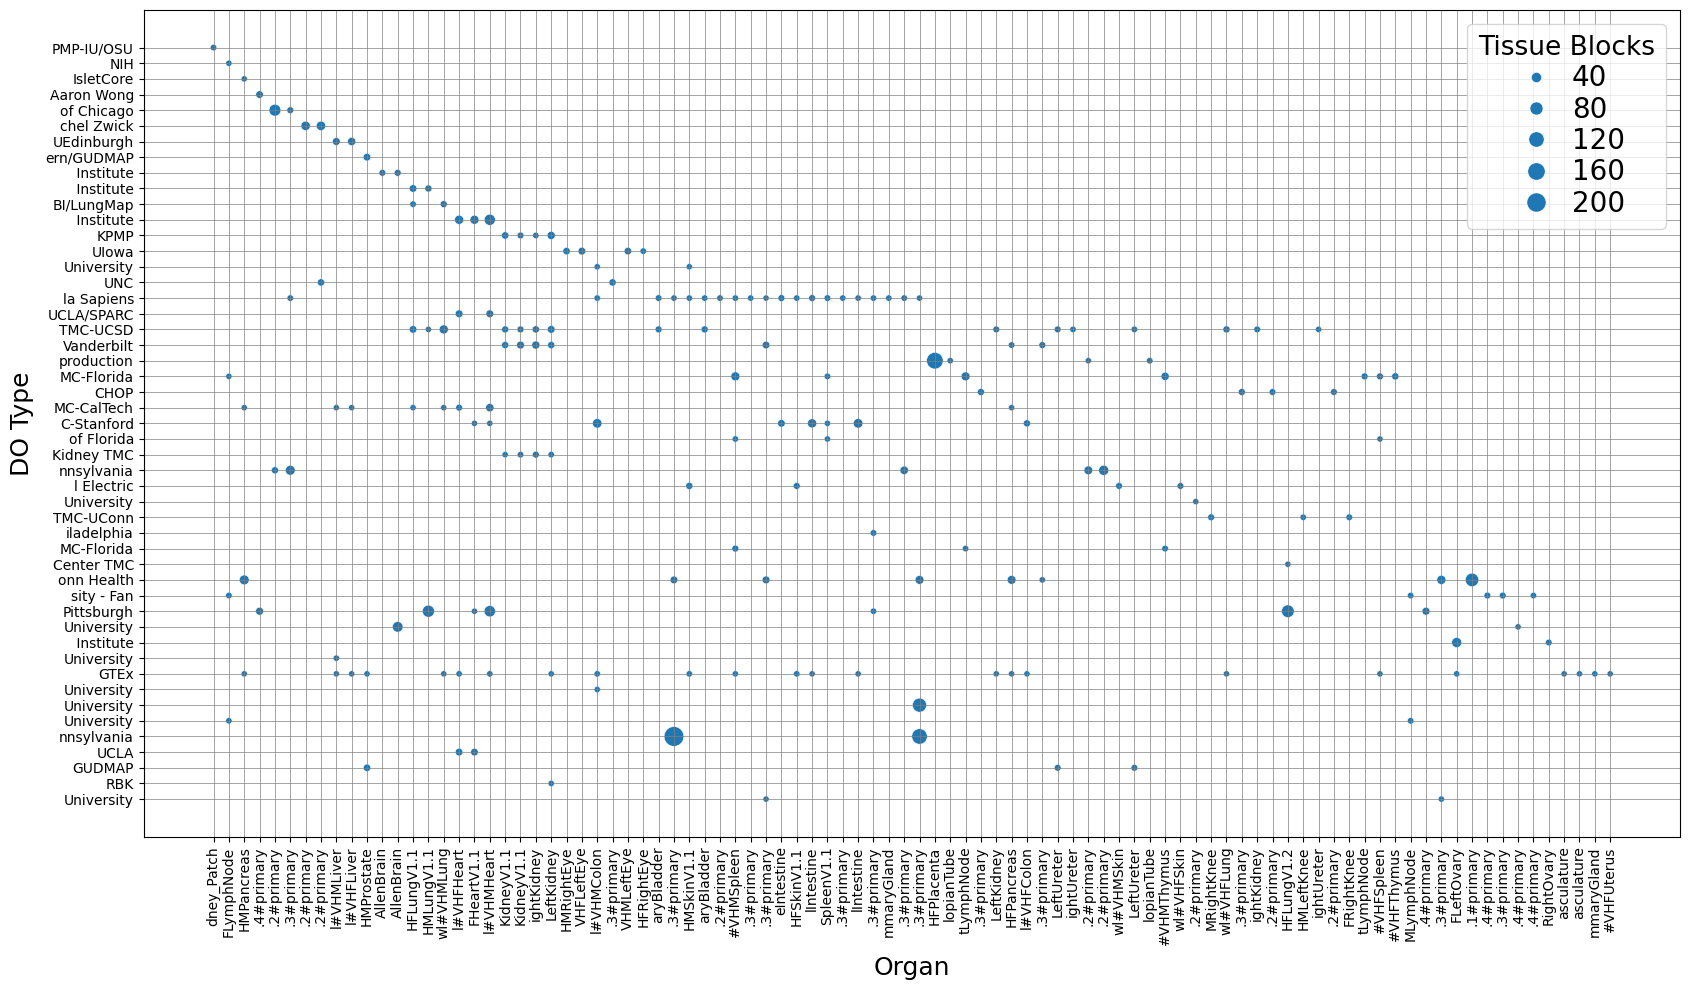

In [68]:
# vega-lite spec: https://cdn.humanatlas.io/hra-dashboard-data/data/digital-objects-per-organ.vl.json

# Create the line plot
g = sns.scatterplot(
    data=df, x="organ", y="provider_name", size="total_count", sizes=(20, 200)
)

# Set white background for figure and axes
g.figure.set_facecolor("white")
g.set_facecolor("white")

# Set thin grey grid lines
g.grid(True, which="major", axis="both", linestyle="-", linewidth=0.5, color="grey")
g.grid(
    True, which="minor", axis="both", linestyle=":", linewidth=0.3, color="lightgrey"
)


# increase figure size to accommodate facet grid
g.figure.set_size_inches(17, 10)

# uncomment if needed
# g.legend_.remove()

ax = plt.gca()

ax.set_xticklabels(
    [label.get_text()[-10:] for label in ax.get_xticklabels()], rotation=90
)

ax.set_yticklabels(
    [label.get_text()[-10:] for label in ax.get_yticklabels()]
)

# Customize the plot
plt.xlabel("Organ", labelpad=8, fontsize=18)
plt.ylabel("DO Type", labelpad=8, fontsize=18)

# Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# adjust legend
legend = g.legend(
    title="Tissue Blocks",
    loc="upper right",
    labelspacing=0.12,
    fontsize=20,
    title_fontsize=19,
    # bbox_to_anchor=(0, -.5)
    handletextpad=0.3,
)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# plt.savefig(f"output/a_dos_per_organ.pdf", dpi=600, format="pdf", bbox_inches="tight")

plt.show()